occyp_type을 encoding하는 게 좋은 방법인지 모르겠다. 그냥 drop했을때 성능이 제일 좋아서 일단 drop하기

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [3]:
import os
os.chdir('C:/Users/eunai/Documents/컴퓨터공부/dacon/open')

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [5]:
data=pd.concat([train, test], axis=0)

In [6]:
data.tail()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,NaN
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,NaN
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,NaN
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0,NaN
9999,36456,F,N,Y,0,270000.0,Working,Higher education,Married,House / apartment,-9154,-187,1,0,0,1,Laborers,2.0,-11.0,NaN


# 데이터 탐색

<AxesSubplot:>

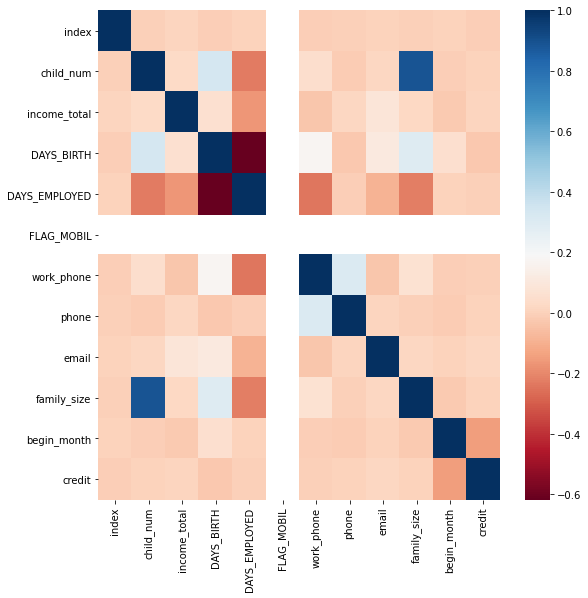

In [7]:
plt.figure(figsize =(9,9))
corr = train.corr()
sns.heatmap(corr,cmap='RdBu')

In [8]:
#family_size와 child_num의 상관관계 매우 높음.
data["family_size"].corr(data["child_num"])

0.8891141560150988

In [9]:
#DAYS_EMPLOYED와 DAYS_BIRTH의 상관관계 비교적 높음.
data["DAYS_EMPLOYED"].corr(data["DAYS_BIRTH"])

-0.6162131099634471

<AxesSubplot:xlabel='family_size', ylabel='Density'>

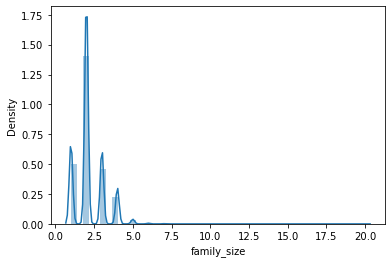

In [10]:
sns.distplot(data["family_size"])

<AxesSubplot:xlabel='child_num', ylabel='Density'>

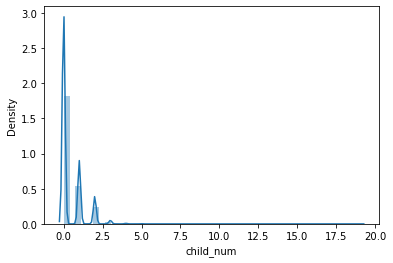

In [11]:
sns.distplot(data["child_num"])

In [12]:
#child_num제거
data.drop("child_num",axis=1,inplace=True)

# 데이터 전처리

In [13]:
def categorical_show(df, col, y_cols='credit'):
    from collections import Counter
    print('unique items:', df[col].unique())
    print()
    counter = Counter(df[col])
    print(counter)
    plt.bar(counter.keys(), counter.values())
    plt.xticks(rotation=30)
    plt.title('people in classes')
    plt.show()
    
    fig, axes = plt.subplots(1, len(df[col].unique()), figsize=(16, 4))

    for i, w in enumerate(df[col].unique()):
        axes[i].hist(df[y_cols][df[col]==w], bins=3, color='dimgray',  rwidth=0.8)
        axes[i].set_title(w)
    plt.show()

### FLAG_MOBIL 제거

In [14]:
data.drop("FLAG_MOBIL",axis=1,inplace=True)
data.shape

(36457, 18)

### binary 변수 변환

In [15]:
data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------


### income_total 구간 처리

In [16]:
data['income_total'] = data['income_total'].astype(object)
data.dtypes

index              int64
gender             int64
car                int64
reality            int64
income_total      object
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

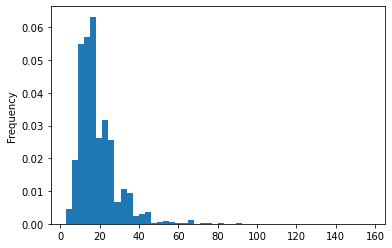

In [17]:
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

In [18]:
count, bin_dividers =np.histogram(data['income_total'], bins=7)

In [19]:
bin_names=['소득'+str(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

### occyp_type 제거

In [20]:
data.drop("occyp_type",axis=1,inplace=True)

### encoding

encoding하고 의미있는 변수만 남겼을 때 오히려 logloss가 늘어남. 그래서 이 작업 취소. 그냥 label_encoder 사용.

In [21]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])
#data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])

In [22]:
data

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,1,1,2,-13899,-4709,0,0,0,2.0,-6.0,1.0
1,1,0,0,1,0,0,4,0,1,-11380,-1540,0,0,1,3.0,-5.0,1.0
2,2,1,1,1,1,4,1,1,1,-19087,-4434,0,1,0,2.0,-22.0,2.0
3,3,0,0,1,0,0,4,1,1,-15088,-2092,0,1,0,2.0,-37.0,0.0
4,4,0,1,1,0,2,1,1,1,-15037,-2105,0,0,0,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,4,2,1,1,-18593,-5434,1,1,0,2.0,-19.0,NaN
9996,36453,1,1,1,0,4,4,0,1,-10886,-1315,1,0,0,2.0,-34.0,NaN
9997,36454,0,0,1,1,4,4,1,1,-21016,-14018,0,0,0,2.0,-55.0,NaN
9998,36455,0,1,0,0,0,4,1,1,-16541,-1085,0,1,0,2.0,-33.0,NaN


### 음수 값 구간 처리

In [23]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    data[variable]=-data[variable]
    count, bin_dividers =np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data[variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data[variable]=label_encoder.fit_transform(data[variable])

In [24]:
make_bin('DAYS_BIRTH', n=10)
#make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

### 이상치 처리

#### 1) income total

<AxesSubplot:xlabel='income_total', ylabel='Density'>

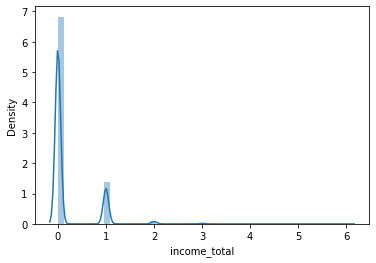

In [25]:
sns.distplot(data["income_total"])

In [26]:
data["income_total"].value_counts()

0    29852
1     6071
2      413
3       96
4       11
6        8
5        6
Name: income_total, dtype: int64

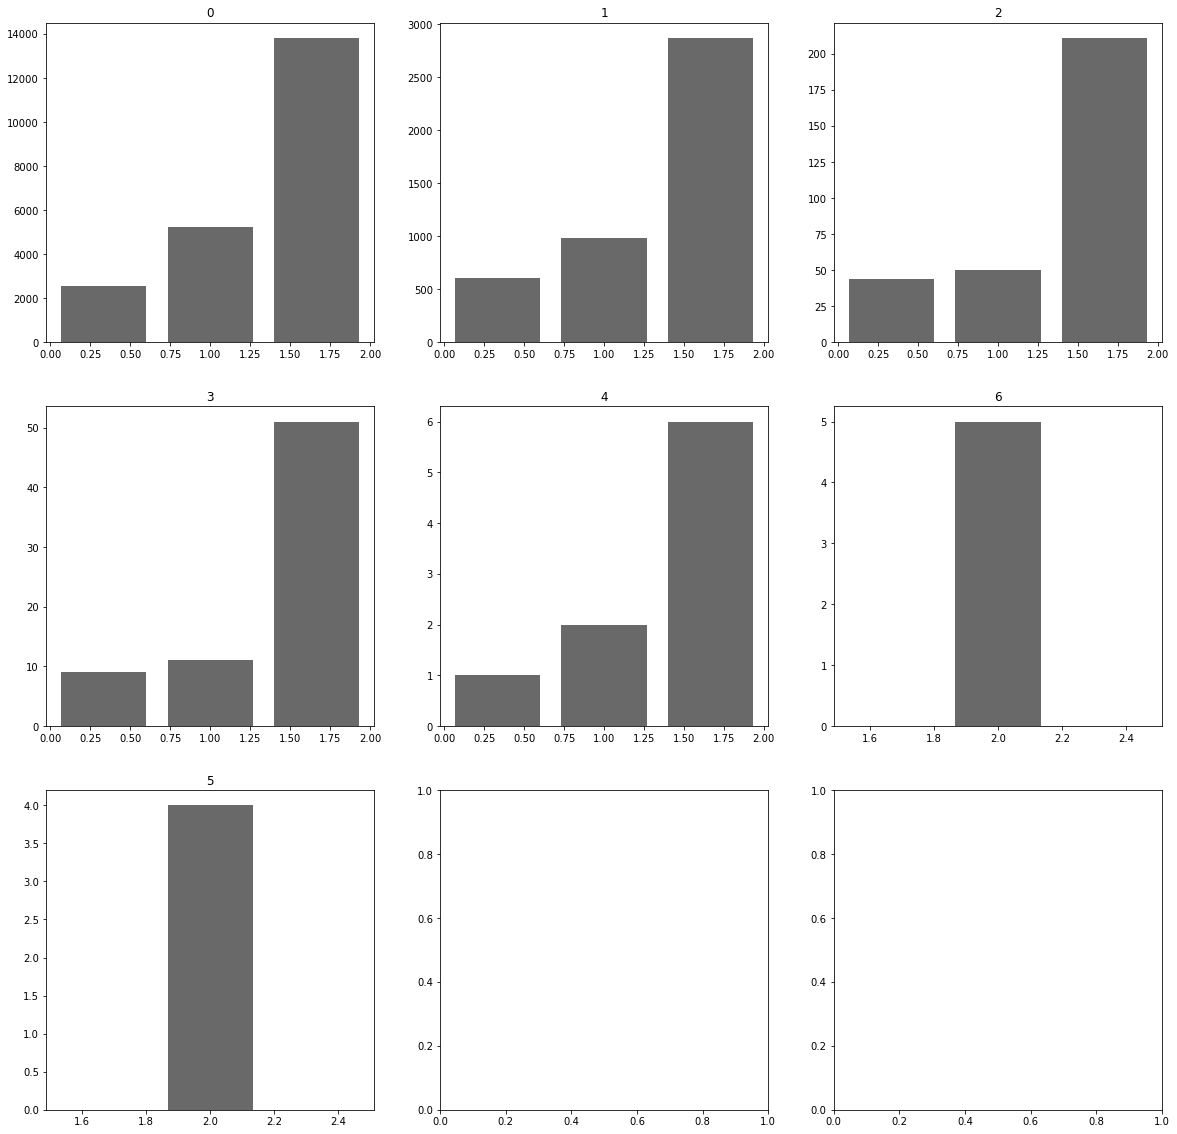

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
j=-1
for i, w in enumerate(data["income_total"].unique()):
    if i%3==0:
        j+=1
        k=0
    axes[j,k].hist(data["credit"][data["income_total"]==w], bins=3, color='dimgray',  rwidth=0.8)
    axes[j,k].set_title(w)
    k+=1
plt.show()

In [28]:
#각 income_total마다 credit의 비율 표를 만들었으면 좋겠는데...

In [101]:
train2=data[:len(data)-10000]
train_inct=pd.crosstab(index=train2["income_total"],columns=train2["credit"])
train_inct

credit,0.0,1.0,2.0
income_total,,,
0,2558,5223,13820
1,610,981,2871
2,44,50,211
3,9,11,51
4,1,2,6
5,0,0,4
6,0,0,5


In [102]:
for i in range(len(train_inct)):
    s=sum(train_inct.loc[i])
    train_inct.iloc[i,0]=train_inct.iloc[i,0]/s
    train_inct.iloc[i,1]=train_inct.iloc[i,1]/s
    train_inct.iloc[i,2]=train_inct.iloc[i,2]/s
train_inct

credit,0.0,1.0,2.0
income_total,,,
0,0.118420,0.241794,0.639785
1,0.136710,0.219857,0.643433
2,0.144262,0.163934,0.691803
3,0.126761,0.154930,0.718310
4,0.111111,0.222222,0.666667
5,0.000000,0.000000,1.000000
6,0.000000,0.000000,1.000000


income_total=5와 income_total=6이 확연히 다른 분포를 보이지만 데이터 수가 너무 적다. outlier로 봐도 되지 않을까...

In [105]:
test2=data[len(data)-10000:]
test2["income_total"].value_counts()

0    8251
1    1609
2     108
3      25
6       3
4       2
5       2
Name: income_total, dtype: int64

아 근데 또 test에 5랑 6에 해당하는 애들이 있긴 하네...마냥 없애기도 뭐함ㅜㅜ

#### 2) DAYS_EMPLOYED

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

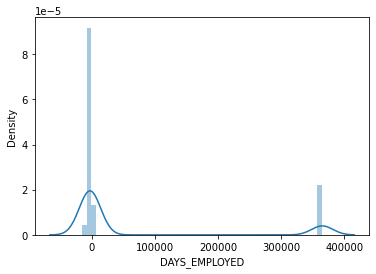

In [47]:
sns.distplot(data["DAYS_EMPLOYED"])

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

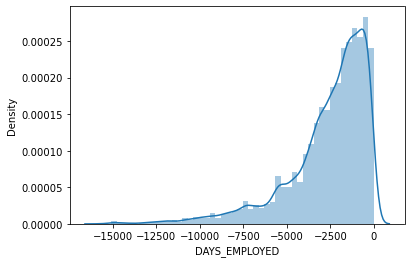

In [48]:
#무직을 뜻하는 365243을 제거한 분포
days_employed=data.loc[data["DAYS_EMPLOYED"]<0]
sns.distplot(days_employed["DAYS_EMPLOYED"])

365243을 어떻게 처리해야 하나~ 그걸 좀 고민해봐야 할듯

#### 3) family_size

<AxesSubplot:xlabel='family_size', ylabel='Density'>

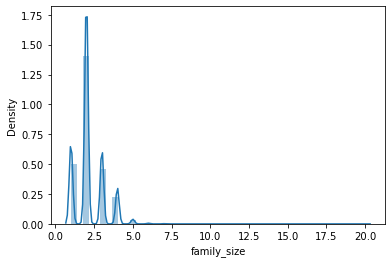

In [49]:
sns.distplot(data["family_size"])

In [50]:
data["family_size"].value_counts()

2.0     19463
1.0      6987
3.0      6421
4.0      3106
5.0       397
6.0        58
7.0        19
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [53]:
data.loc[data["family_size"]>=9]

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
8462,8462,1,1,1,0,4,4,2,1,5,-1689,0,0,0,15.0,0,2.0
9021,9021,1,1,1,0,4,4,2,1,5,-1689,0,0,0,15.0,3,2.0
10731,10731,0,0,1,0,4,4,3,1,2,-1853,1,1,0,20.0,0,2.0
25313,25313,0,0,0,0,4,4,1,1,3,-1649,1,1,0,9.0,1,2.0
25390,25390,1,1,1,0,4,4,2,1,5,-1689,0,0,0,15.0,2,2.0
25638,25638,0,0,0,0,4,4,1,1,3,-1649,1,1,0,9.0,2,2.0


family_size가 9이상이면 test에는 아예 있지도 않음. credit도 죄다 2. 그냥 제거하는 게 좋지 않을까...

In [59]:
ind=data.loc[data["family_size"]>=9].index
data=data.drop(ind)
data.shape

(36449, 17)

### 인덱스 제거

In [107]:
data.tail()

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
9995,36452,0,1,1,0,4,2,1,1,6,-5434,1,1,0,2.0,1,NaN
9996,36453,1,1,1,0,4,4,0,1,1,-1315,1,0,0,2.0,2,NaN
9997,36454,0,0,1,1,4,4,1,1,7,-14018,0,0,0,2.0,3,NaN
9998,36455,0,1,0,0,0,4,1,1,5,-1085,0,1,0,2.0,2,NaN
9999,36456,0,0,1,1,4,1,1,1,0,-187,0,0,1,2.0,0,NaN


In [193]:
data.drop("index",axis=1,inplace=True)

In [194]:
data.tail()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,family_size,begin_month,credit,Realty agents,Secretaries,HR staff,IT staff,Low-skill Laborers,Waiters/barmen staff,No job
level_0,,,,,,,,,,,,,,,,,,,,,
9995,0,1,1,0,0,4,2,1,1,6,...,2.0,1,NaN,0,0,0,0,0,0,0
9996,1,1,1,0,0,4,4,0,1,1,...,2.0,2,NaN,0,0,0,0,0,0,0
9997,0,0,1,0,1,4,4,1,1,7,...,2.0,3,NaN,0,0,0,0,0,0,0
9998,0,1,0,0,0,0,4,1,1,5,...,2.0,2,NaN,0,0,0,0,0,0,0
9999,0,0,1,0,1,4,1,1,1,0,...,2.0,0,NaN,0,0,0,0,0,0,0


# 데이터 모델링

In [195]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]

In [196]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 23)
(19842, 1)
Validation set: 
(6615, 23)
(6615, 1)
log_loss: 1.4736913185286482


In [198]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:1.5142101909644876
FOLD 1 : logloss:1.5796326024992433
FOLD 2 : logloss:1.4241096151297337
FOLD 3 : logloss:1.5754220580180494
FOLD 4 : logloss:1.496526082186582
Mean:1.5179801097596193


In [199]:
my_submission

array([[0.03836667, 0.12706667, 0.83456667],
       [0.18197619, 0.21575238, 0.60227143],
       [0.30214444, 0.04047143, 0.65738413],
       ...,
       [0.00733333, 0.02393333, 0.96873333],
       [0.29727857, 0.59255952, 0.1101619 ],
       [0.07317857, 0.63681111, 0.29001032]])

In [200]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [201]:
submission.loc[:,1:]=my_submission

In [202]:
submission

,index,0,1,2
0,26457,0.038367,0.127067,0.834567
1,26458,0.181976,0.215752,0.602271
2,26459,0.302144,0.040471,0.657384
3,26460,0.174779,0.035500,0.789721
4,26461,0.024167,0.663667,0.312167
...,...,...,...,...
9995,36452,0.091630,0.218151,0.690219
9996,36453,0.515500,0.105167,0.379333
9997,36454,0.007333,0.023933,0.968733
9998,36455,0.297279,0.592560,0.110162


In [203]:
submission.to_csv('C:\\Users\\eunai\\Documents\\컴퓨터공부\dacon\\baseline_submission_6.csv', index=False)